# Find distribution of local maxima in a Gaussian Random Field

In this notebook, I evaluate different known distributions for local maxima in a Gaussian Random Field.  I followed several steps to (a) look at the distribution through simulations, (b) apply different possible approaches to find the distribution.

It seems that none of these are applicable for local maxima without applying a filtering threshold.

# 1. Simulate random fields (without activation) and extract local maxima

In a first step, I 
- Simulate a guassian random field using nipype.  This field is huge (500x500x500) and therefore memory-intensive to ensure we have lots of local maxima.
- Look at the GRF.
- Export the GRF to a nifti file.  Before saving the data, I make sure all values are positive, because step (d) only extracts local maxima that are above 0.
- Extract all local maxima using nipype and fsl cluster.
- Look at the table of local maxima and print the total number of peaks.
- Look at the distribution of these maxima.

#### Import libraries 

In [1]:
% matplotlib inline
import os
import numpy as np
import nibabel as nib
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import nipy.algorithms.statistics.rft as rft
from __future__ import print_function, division
import math
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import pandas as pd
import nipy.algorithms.statistics.intvol as intvol
from matplotlib import colors
import scipy.stats as stats


#### Simulate very large RF

In [2]:
smooth_FWHM = 3
smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(500,500,500),noise_level=1)

#### Show part of the RF (20x20x1)

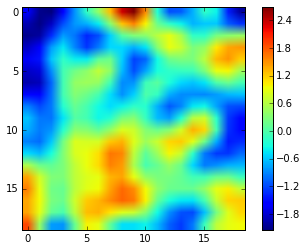

In [3]:
plt.figure(figsize=(6,4))
plt.imshow(data[1:20,1:20,1])
plt.colorbar()
plt.show()

#### Save RF

In [4]:
minimum = data.min()
newdata = data - minimum #little trick because fsl.model.Cluster ignores negative values
img=nib.Nifti1Image(newdata,np.eye(4))
img.to_filename("files/RF.nii.gz")

#### Run fsl cluster to extract local maxima

In [5]:
cl=fsl.model.Cluster()
cl.inputs.threshold = 0
cl.inputs.in_file="files/RF.nii.gz"
cl.inputs.out_localmax_txt_file="files/locmax.txt"
cl.inputs.num_maxima=1000000
cl.inputs.connectivity=26
cl.inputs.terminal_output='none'
cl.run()

#### Read and print top of file with peaks ,  print total number of peaks.

In [6]:
peaks = pd.read_csv("files/locmax.txt",sep="\t").drop('Unnamed: 5',1)
peaks.Value = peaks.Value + minimum
peaks[:5]

,Cluster Index,Value,x,y,z
0,1,6.668672,66,0,243
1,1,6.468672,468,0,255
2,1,6.268672,227,499,401
3,1,6.168672,291,499,191
4,1,6.168672,312,499,330


In [7]:
len(peaks)

615036

#### Plot histogram local maxima

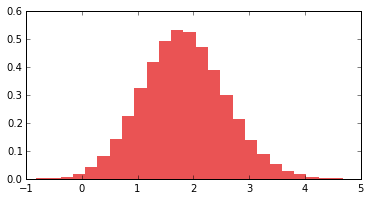

In [8]:
col=cb.qualitative.Set1_8.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(peaks.Value,40,normed=1,facecolor=col[0],alpha=0.75,lw=0)
ax.set_xlim([-1,5])
plt.show()

# 2. First approach: analytically derived distribution of local maxima above u 

#a. (Cheng & Schwartzman, 2015)
#b. RFT

[Cheng and Schwartzman](https://www.dropbox.com/s/goo6bj5vw82gd8b/Cheng%2C%20Schwartzman%20-%202015%20-%20Extremes%20-%20Distribution%20of%20the%20height%20of%20local%20maxima%20of%20Gaussian%20random%20fields.pdf?dl=0) recently published a paper in which they derive a distribution of local maxima over a certain threshold.  They make (like RFT) the assumption that the field is a GRF whose interior is non-empty... A consequence is that we can only compute this when the threshold is high enough to ensure there are only blobs and no holes.  We'll take a look how the theoretical distribution performs for lower thresholds.  This is their derived distribution:

For all local maxima above threshold $v$, extending $u$ above this threshold,

For each $t_0 \in T$ and each fixed $u>0$, as $v \rightarrow \infty$,

\begin{equation*}
F_t(u,v) = \frac{(u+v)^{N-1}e^{-(u+v)^2/2}}{v^{N-1}e^{-v^2/2}}
\end{equation*}

Below you can see that the approximation indeed only works well on very high thresholds, and therefore cannot be used to obtain the full distribution of all peaks.

We also compare with the random field theory approximation, with u the threshold:

\begin{equation}
F_t(u,t_0) = u e^{-u(t_0 - u)}
\end{equation}

#### Function for pdf of peaks given a certain threshold

In [9]:
def nulprobdens(exc,peaks):
	v = exc
	u = peaks - v
	f0 = (2+(u+v)**2)*(u+v)*np.exp(-(u+v)**2/2)/(v**2*np.exp(-v**2/2))
	return f0

#### Function for pdf of peaks given a certain threshold, RFT

In [29]:
def nulprobdensRFT(exc,peaks):
    f0 = exc*np.exp(-exc*(peaks-exc))
    return f0

#### Compute density function over a range with different excursion thresholds 

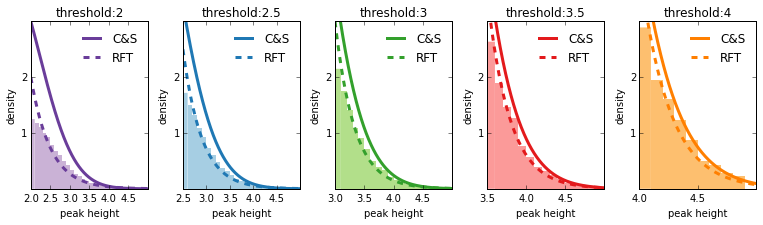

In [37]:
fig,axs=plt.subplots(1,5,figsize=(13,3))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()
thresholds=[2,2.5,3,3.5,4]
bins=np.arange(2,5,0.5)
x=np.arange(2,10,0.0001)

twocol=cb.qualitative.Paired_10.mpl_colors
for i in range(5):
    thr=thresholds[i]
    axs[i].hist(peaks.Value[peaks.Value>thr],lw=0,facecolor=twocol[i*2-2],normed=True,bins=np.arange(thr,5,0.1))
    axs[i].set_xlim([thr,5])
    axs[i].set_ylim([0,3])
    xn = x[x>thr]
    yn = nulprobdens(thr,xn)    
    ynb = nulprobdensRFT(thr,xn)
    axs[i].plot(xn,yn,color=twocol[i*2-1],lw=3,label="C&S")
    axs[i].plot(xn,ynb,color=twocol[i*2-1],lw=3,linestyle="--",label="RFT")
    axs[i].set_title("threshold:"+str(thr))
    axs[i].set_xticks(np.arange(thr,5,0.5))
    axs[i].set_yticks([1,2])
    axs[i].legend(loc="upper right",frameon=False)
    axs[i].set_xlabel("peak height")
    axs[i].set_ylabel("density")
plt.show()

In this figure, we see the observed tail distribution of the local maxima (light colored) in our simulated data.  The thick line represents the theoretical distribution of the local maxima above a certain threshold. It is only a good approximation for really high thresholds. RFT works better for lower thresholds.

# 3. Second approach: what can we use the Euler Characteristic for?

The [Euler Characteristic](https://en.wikipedia.org/wiki/Euler_characteristic) is a topological invariant that represents for a certain threshold applied to a certain random field \#peaks - \#holes.  Therefore, again, if the threshold is high enough (there are no holes), it computes the number of peaks.  

If we compute the EC for a range of thresholds (above a certain threshold), we can construct a pdf of peak heights.  It should be noted that the number of peaks is dependent of the smoothness, but this dependency can be taken out by dividing the smoothness by the total volume as a correcting factor.

This principle has led to a theoretical approximation of the pdf of peaks, which is closely related to the approach of Cheng \& Schwartzmann.


#### Let's first look at the masks that result from our random field with certain thresholds

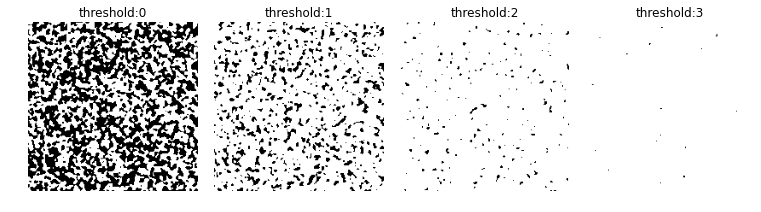

In [168]:
fig,axs=plt.subplots(1,4,figsize=(13,7))
fig.subplots_adjust(hspace = .1, wspace=0.1)
axs=axs.ravel()
thresholds=np.arange(0,4,1)
cmap = colors.ListedColormap(['white', 'black'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for t in range(len(thresholds)):
    mask = np.zeros(shape=data.shape,dtype=np.intp)
    mask[data>thresholds[t]]=1
    axs[t].imshow(mask[1:200,1:200,20],cmap=cmap,norm=norm)
    axs[t].set_title("threshold:"+str(thresholds[t]))
    axs[t].patch.set_visible(False)
    axs[t].axis('off')


#### Now we'll look at the number of peaks and the Euler Characteristic against the threshold.

In [17]:
EulerDens = []
EulerDensInv = []
urange = np.arange(-4,4,0.3)
for t in urange:
    mask = np.zeros(shape=data.shape,dtype=np.intp)
    mask[data>t]=1
    EulerDens.append(intvol.EC3d(mask))
    mask2 = 1-mask
    EulerDensInv.append(intvol.EC3d(mask2))


In [19]:
sumpeak = []
for t in urange:
    sumpeak.append(sum(peaks.Value>t))


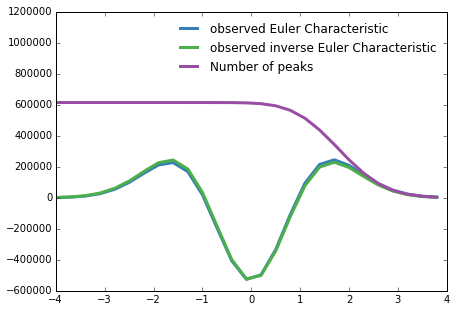

In [54]:
plt.figure(figsize=(7,5))
plt.plot(urange,EulerDens,color=col[1],lw=3,label="observed Euler Characteristic")
plt.plot(urange,EulerDensInv,color=col[2],lw=3,label="observed inverse Euler Characteristic")
plt.plot(urange,sumpeak,color=col[3],lw=3,label="Number of peaks")
plt.legend(loc="upper right",frameon=False)
plt.ylim([-600000,1200000])
plt.show()

In this plot we can indeed see that the Euler Characteristic gives the number of peaks, but only above a certain threshold that is high enough.  Below these higher thresholds, is gives \# peaks - \# holes.  Is there a way to estimate the number of holes in the presence of peaks using the EC?  I don't think so, it's the exact same problem as the number of paeks in the presence of holes?  Therefore the Euler Characteristic cannot give us information for lower thresholds.

# 4. Third approach: peaks as the maximum of something of which we know the distribution?

The above procedures use the fact that these fields are (should be) continuous fields.  However, what comes out of the scanner is **not** continuous at all.  We make it __more__ continuous by applying a smoothing kernel, which allows to use these processes.  However, I wonder, is it possible to look at the peaks simply as the maximum of a sample of a known distribution?

Can we look at the random fields as multivariate normal with a correlation structure dependent on the smoothness?

Here the smoothness comes into play!  How does smoothness affect the distribution of the peaks?

#### First simulate random fields for different smoothnesses. 

In [180]:
smoothnesses = [0,3,6,9]
minima = []
for sm in range(len(smoothnesses)):
    smooth_FWHM = smoothnesses[sm]
    smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
    data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(500,500,500),noise_level=1)
    minimum = data.min()
    newdata = data - minimum #little trick because fsl.model.Cluster ignores negative values
    minima.append(minimum)
    img=nib.Nifti1Image(newdata,np.eye(4))
    img.to_filename(os.path.join("files/RF_"+str(sm)+".nii.gz"))
    cl=fsl.model.Cluster()
    cl.inputs.threshold = 0
    cl.inputs.in_file=os.path.join("files/RF_"+str(sm)+".nii.gz")
    cl.inputs.out_localmax_txt_file=os.path.join("files/locmax_"+str(sm)+".txt")
    cl.inputs.num_maxima=10000000
    cl.inputs.connectivity=26
    cl.inputs.terminal_output='none'
    cl.run()


#### Look at the distribution of the voxels?

We simulated the random fields to be a GRF, from a normal distribution.  Here you can see that indeed the distribution is normal independent from the smoothness.

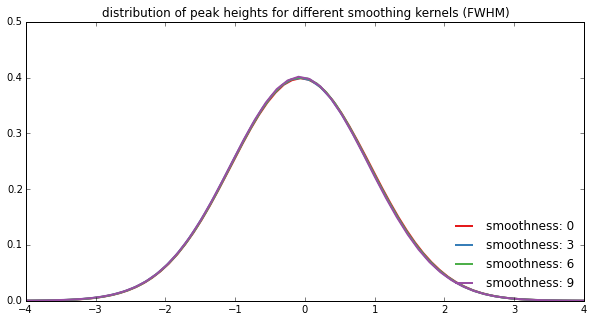

In [182]:
col=cb.qualitative.Set1_8.mpl_colors+cb.qualitative.Set2_8.mpl_colors
plt.figure(figsize=(10,5))
ax=plt.subplot(111)
for sm in range(len(smoothnesses)):
    file = os.path.join("files/RF_"+str(sm)+".nii.gz")
    tvals = nib.load(file).get_data().astype('float64')+minima[sm]  
    values, base = np.histogram(tvals,100,normed=1)
    ax.plot(base[:-1],values,label="smoothness: "+str(smoothnesses[sm]),color=col[sm],lw=2)
ax.set_xlim([-4,4])
ax.set_ylim([0,0.5])
ax.legend(loc="lower right",frameon=False)
ax.set_title("distribution of peak heights for different smoothing kernels (FWHM)")
plt.show()

#### So how about the distribution of the maximum of a sample of these distributions?

In [173]:
all = []
for sm in range(len(smoothnesses)):
    peaks = pd.read_csv(os.path.join("files/locmax_"+str(sm)+".txt"),sep="\t").drop('Unnamed: 5',1).Value
    peaks = peaks + minima[sm]
    all.append(peaks)


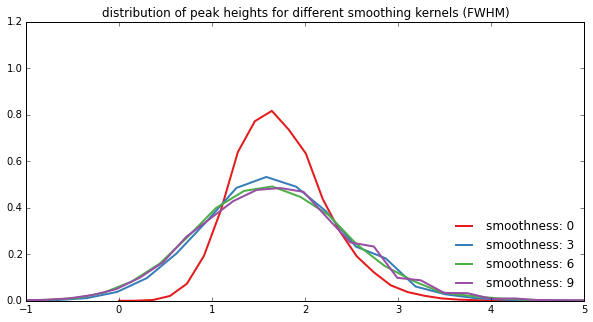

In [183]:
col=cb.qualitative.Set1_8.mpl_colors+cb.qualitative.Set2_8.mpl_colors
plt.figure(figsize=(10,5))
ax=plt.subplot(111)
for sm in range(len(smoothnesses)):
    values, base = np.histogram(all[sm],30,normed=1)
    ax.plot(base[:-1],values,label="smoothness: "+str(smoothnesses[sm]),color=col[sm],lw=2)
ax.set_xlim([-1,5])
ax.set_ylim([0,1.2])
ax.legend(loc="lower right",frameon=False)
ax.set_title("distribution of peak heights for different smoothing kernels (FWHM)")
plt.show()


As expected, from a certain smoothness (3 x voxel size), the distribution remains the same.

## First: the distribution without smoothness!

The RF with smoothness 0 should be just normally distributed values without correlation.  The peaks with smoothness 0 should be just maxima of a sample of normally distributed values.  We know the distribution of a sample with normally distribution values from order statistics:

$f_{max}(x) = nF(x)^{n-1}f(x)$

#### This is to show that the distribution of the maximum of the sample is the right one.  
* Simulate n normally distributed values
* Take the maximum
* Compute for a range of values the distribution of the maximum
* Show histogram of simulated maxima with the pdf on top

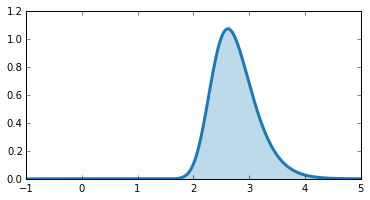

In [198]:
# random sample

smplm = []

for i in range(100000):
    smpl = np.random.standard_normal((n,))
    smplm.append(max(smpl))

# distribution

xm = np.arange(-1,5,0.001)
ym = n*stats.norm.cdf(xm)**(n-1)*stats.norm.pdf(xm)

# histogram

twocol=cb.qualitative.Paired_10.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(smplm,100,normed=1,facecolor=twocol[0],alpha=0.75,lw=0)
ax.plot(xm,ym,color=twocol[1],lw=3)
ax.set_xlim([-1,5])
plt.show()

#### Now can we just state that the peaks in our unsmoothed random field is the maxima of a sample?

First: the sample size is variable!  Let's try it on the average sample size, i.e. the average number of voxels per peak.

In [200]:
n = (500**3)/len(all[1])
n

203.16118808662793

#### Show histogram of peaks of uncorrected field with the distribution of maximum of a sample of size n. 

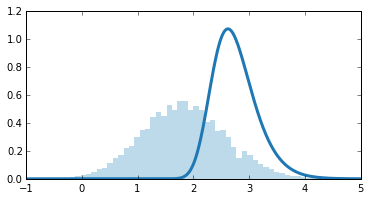

In [199]:
# distribution of a maximum

xm = np.arange(-1,5,0.001)
ym = n*stats.norm.cdf(xm)**(n-1)*stats.norm.pdf(xm)

# histogram

twocol=cb.qualitative.Paired_10.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(all[1],100,normed=1,facecolor=twocol[0],alpha=0.75,lw=0)
ax.plot(xm,ym,color=twocol[1],lw=3)
ax.set_xlim([-1,5])
plt.show()

# Ok, I'm stuck.

The stuff below is the maximum of a sample with correlation.  We have the distribution, but if it doesn't work for uncorrelated values, it's not going to work for correlated values.  So I leave it here but it's non-informative.

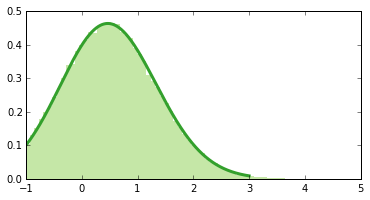

In [130]:
# random sample

smplmc = []
n = 2
mean = [0,0]
r = 0.2
cov = [[1,r],[r,1]]

for i in range(100000):
    smpl = np.random.multivariate_normal(mean,cov,int(n/n))
    smplmc.append(np.max(smpl))

# distribution

xmc = np.arange(-2,3,0.001)
corf = (1-r)/np.sqrt(1-r**2)
ymc = n*stats.norm.cdf(corf*xmc)**(n-1)*stats.norm.pdf(xmc)

# histogram

twocol=cb.qualitative.Paired_10.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(smplmc,100,normed=1,facecolor=twocol[2],alpha=0.75,lw=0)
ax.plot(xmc,ymc,color=twocol[3],lw=3)
ax.set_xlim([-1,5])
plt.show()
 

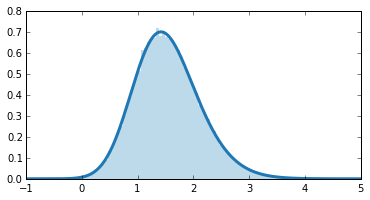

In [138]:
# random sample

smplmc = []
n = 10
mean = np.array([0,0,0,0,0,0,0,0,0,0])
r = 0.5
cov = np.array([[1,r,r,r,r,r,r,r,r,r],
       [r,1,r,r,r,r,r,r,r,r],
       [r,r,1,r,r,r,r,r,r,r],
       [r,r,r,1,r,r,r,r,r,r],
       [r,r,r,r,1,r,r,r,r,r],
       [r,r,r,r,r,1,r,r,r,r],
       [r,r,r,r,r,r,1,r,r,r],
       [r,r,r,r,r,r,r,1,r,r],
       [r,r,r,r,r,r,r,r,1,r],
       [r,r,r,r,r,r,r,r,r,1]
      ])

for i in range(100):
    smpl = np.random.multivariate_normal(mean,cov,int(n/n))
    smplmc.append(np.max(smpl))

# distribution (just max of gaussian normal)

xm = np.arange(-1,5,0.001)
corf = (1-r)/np.sqrt(1-r**2)
ym = n*stats.norm.cdf(xm)**(n-1)*stats.norm.pdf(xm)

# histogram

twocol=cb.qualitative.Paired_10.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(smplm,100,normed=1,facecolor=twocol[0],alpha=0.75,lw=0)
ax.plot(xm,ym,color=twocol[1],lw=3)
ax.set_xlim([-1,5])
plt.show()

In [1]:
newline

NameError: name 'newline' is not defined